In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
TRAIN_DIR = '../input/seg_train/'
TEST_DIR = '../input/seg_test/'

batch_size = 64

model_name = "ResNet50"

In [ ]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
TRAIN_DIR = '../input/seg_train/'
TEST_DIR = '../input/seg_test/'

batch_size = 64

model_name = "ResNet50"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

In [5]:
# Data Loader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size, num_workers=2)


In [6]:
# ResNet-18モデルの定義
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        self.resnet = models.resnet50(weights="IMAGENET1K_V1")  # 事前学習済みのResNet-18モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [7]:
# 2. モデルの構築
model = CustomResNet50(num_classes=6).to(device)


In [8]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [9]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Train Loss: 0.49713218171302587, Val Loss: 0.5576112925550564, Train Acc: 0.8267065697591564, Val Acc: 0.805


Epoch 2/50, Train Loss: 0.36883488522000507, Val Loss: 0.37470621984214225, Train Acc: 0.8729514037337893, Val Acc: 0.8616666666666667


Epoch 3/50, Train Loss: 0.3145100834979314, Val Loss: 0.33150820037785994, Train Acc: 0.8911928174433519, Val Acc: 0.8736666666666667


Epoch 4/50, Train Loss: 0.2979225297224576, Val Loss: 0.32729144645062214, Train Acc: 0.8964657260937723, Val Acc: 0.8856666666666667


Epoch 5/50, Train Loss: 0.27231442173049875, Val Loss: 0.3005925607966616, Train Acc: 0.9034487672794641, Val Acc: 0.894


Epoch 6/50, Train Loss: 0.25805432029646824, Val Loss: 0.31135777134245185, Train Acc: 0.9105030639874591, Val Acc: 0.886


Epoch 7/50, Train Loss: 0.2416986999990733, Val Loss: 0.27341566062185596, Train Acc: 0.9124269630896394, Val Acc: 0.9056666666666666


Epoch 8/50, Train Loss: 0.2243067045870437, Val Loss: 0.26556692888682826, Train Acc: 0.9187687045746046, Val Acc: 0.909


Epoch 9/50, Train Loss: 0.21457280637058493, Val Loss: 0.3155147253060119, Train Acc: 0.9235428245689041, Val Acc: 0.8896666666666667


Epoch 10/50, Train Loss: 0.2161614399862616, Val Loss: 0.2855183145705056, Train Acc: 0.923614080091207, Val Acc: 0.8963333333333333


Epoch 11/50, Train Loss: 0.2061052464595124, Val Loss: 0.24565238481823434, Train Acc: 0.9279606669516888, Val Acc: 0.9173333333333333


Epoch 12/50, Train Loss: 0.1933956394082607, Val Loss: 0.2905747514772922, Train Acc: 0.93038335470999, Val Acc: 0.9


Epoch 13/50, Train Loss: 0.1893467794610485, Val Loss: 0.25097174239047665, Train Acc: 0.9323072538121704, Val Acc: 0.913


Epoch 14/50, Train Loss: 0.17391999033556138, Val Loss: 0.28039254610763586, Train Acc: 0.9360837964942283, Val Acc: 0.906


Epoch 15/50, Train Loss: 0.17205736867777288, Val Loss: 0.2551547026142795, Train Acc: 0.9382214621633177, Val Acc: 0.9116666666666666


Epoch 16/50, Train Loss: 0.17374554630283895, Val Loss: 0.2806601679705559, Train Acc: 0.9351574747042896, Val Acc: 0.9123333333333333


Epoch 17/50, Train Loss: 0.15534899218781897, Val Loss: 0.27750649017856477, Train Acc: 0.9434231152914351, Val Acc: 0.903


Epoch 18/50, Train Loss: 0.15483987697115228, Val Loss: 0.29111281895336316, Train Acc: 0.9431380932022232, Val Acc: 0.9093333333333333


Epoch 19/50, Train Loss: 0.14677482632469369, Val Loss: 0.3287368875165331, Train Acc: 0.9467008693173721, Val Acc: 0.8883333333333333


Epoch 20/50, Train Loss: 0.1487485594945411, Val Loss: 0.3077450450311633, Train Acc: 0.943993159469859, Val Acc: 0.905


Epoch 21/50, Train Loss: 0.14339288747678064, Val Loss: 0.3035584931816668, Train Acc: 0.9462733361835542, Val Acc: 0.903


Epoch 22/50, Train Loss: 0.12667036787117725, Val Loss: 0.3111795126361416, Train Acc: 0.9513324782670657, Val Acc: 0.909


Epoch 23/50, Train Loss: 0.11809664575136415, Val Loss: 0.3259467828642339, Train Acc: 0.9557503206498503, Val Acc: 0.905


Epoch 24/50, Train Loss: 0.10673777066749525, Val Loss: 0.4181228037675882, Train Acc: 0.9605244406441499, Val Acc: 0.887


Epoch 25/50, Train Loss: 0.11856565388030113, Val Loss: 0.3260672487308608, Train Acc: 0.9573179421405159, Val Acc: 0.9046666666666666


Epoch 26/50, Train Loss: 0.0993218893636035, Val Loss: 0.31535115366444944, Train Acc: 0.9634459170585721, Val Acc: 0.9053333333333333


Epoch 27/50, Train Loss: 0.10438123153156886, Val Loss: 0.3315899395681125, Train Acc: 0.9606669516887559, Val Acc: 0.9013333333333333


Epoch 28/50, Train Loss: 0.09306225505950924, Val Loss: 0.34831442751307434, Train Acc: 0.9655835827276614, Val Acc: 0.9016666666666666


Epoch 29/50, Train Loss: 0.10676764866941052, Val Loss: 0.3250401424283677, Train Acc: 0.9596693743765142, Val Acc: 0.899


Epoch 30/50, Train Loss: 0.09060332810582772, Val Loss: 0.30981595946000295, Train Acc: 0.967008693173721, Val Acc: 0.913


Epoch 31/50, Train Loss: 0.08817631164012843, Val Loss: 0.3872798817985235, Train Acc: 0.9671512042183269, Val Acc: 0.8933333333333333


Epoch 32/50, Train Loss: 0.08859533405560813, Val Loss: 0.3706735690530548, Train Acc: 0.9680775260082657, Val Acc: 0.9013333333333333


Epoch 33/50, Train Loss: 0.08035795320225157, Val Loss: 0.34650625737800084, Train Acc: 0.9696451474989312, Val Acc: 0.91


Epoch 34/50, Train Loss: 0.07915791827913153, Val Loss: 0.35041119771058415, Train Acc: 0.970357702721961, Val Acc: 0.9103333333333333


Epoch 35/50, Train Loss: 0.07420157010934941, Val Loss: 0.3428667253081469, Train Acc: 0.9711415134672937, Val Acc: 0.9086666666666666


Epoch 36/50, Train Loss: 0.06957536851179245, Val Loss: 0.3889231133148411, Train Acc: 0.973492945703292, Val Acc: 0.9013333333333333


Epoch 37/50, Train Loss: 0.06782400910423635, Val Loss: 0.371370945853414, Train Acc: 0.9744192674932307, Val Acc: 0.9033333333333333


Epoch 38/50, Train Loss: 0.06462324701130526, Val Loss: 0.37277689872388825, Train Acc: 0.9744192674932307, Val Acc: 0.916


Epoch 39/50, Train Loss: 0.06695006453308817, Val Loss: 0.39173992402093644, Train Acc: 0.9758443779392902, Val Acc: 0.9123333333333333


Epoch 40/50, Train Loss: 0.050067421937676056, Val Loss: 0.34702904954394126, Train Acc: 0.9814735642012256, Val Acc: 0.9096666666666666


Epoch 41/50, Train Loss: 0.05174128346136648, Val Loss: 0.42131320026392327, Train Acc: 0.9809035200228018, Val Acc: 0.9026666666666666


Epoch 42/50, Train Loss: 0.06601440127445682, Val Loss: 0.3463651729708022, Train Acc: 0.9754881003277754, Val Acc: 0.9086666666666666


Epoch 43/50, Train Loss: 0.04572967916980097, Val Loss: 0.4239269073017219, Train Acc: 0.9810460310674077, Val Acc: 0.904


Epoch 44/50, Train Loss: 0.057171509456586896, Val Loss: 0.3669706872398742, Train Acc: 0.9779820436083797, Val Acc: 0.905


Epoch 45/50, Train Loss: 0.06192889572206255, Val Loss: 0.36600933856073214, Train Acc: 0.9759156334615933, Val Acc: 0.9073333333333333


Epoch 46/50, Train Loss: 0.05210725710404076, Val Loss: 0.40898937523424467, Train Acc: 0.9807610089781958, Val Acc: 0.9086666666666666


Epoch 47/50, Train Loss: 0.05544181719218215, Val Loss: 0.39456241141306236, Train Acc: 0.9790508764429243, Val Acc: 0.901


Epoch 48/50, Train Loss: 0.04483986408322131, Val Loss: 0.5001942952054533, Train Acc: 0.9836824853926179, Val Acc: 0.898


Epoch 49/50, Train Loss: 0.04976766820216645, Val Loss: 0.39655807841336355, Train Acc: 0.9822573749465584, Val Acc: 0.9063333333333333


Epoch 50/50, Train Loss: 0.03929779608840268, Val Loss: 0.4304741871087475, Train Acc: 0.9858201510617073, Val Acc: 0.9096666666666666


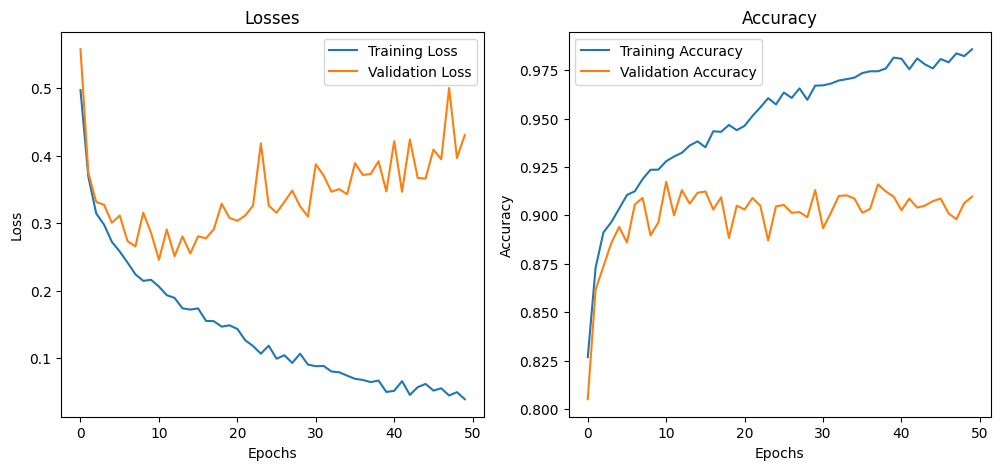

In [11]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
